# Python and Analytics workshop - Using Natural Language Understanding and Sentiment

In this portion of the workshop, we'll use an instance of [Watson Natural Language Understanding](https://cloud.ibm.com/catalog/services/natural-language-understanding) to gather insights into data.

Watson Natural Language Understanding is a cloud native product that uses deep learning to extract metadata from text such as entities, keywords, categories, sentiment, emotion, relations, and syntax.
There is a rich [API](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python) that we will use along with the [Watson Python SDK](https://github.com/watson-developer-cloud/python-sdk) to analyze our data.

## Contents

- [1.0 Setup - install modules](#setup)
- [2.0 Test NLU APIs](#test)
- [3.0 Import Data and Setup Pandas Dataframe ](#pandas)
- [4.0 Clean and Prepare data for NLU scoring](#clean)
- [5.0 Analyze response from NLU ](#analyze)
- [6.0 Get sentiment by row](#sentiment-row)
- [7.0 Graph with matplotlib](#graph)



## 1.0 Setup - Install Modules<a name="setup"></a>

We use the [Watson Python SDK](https://github.com/watson-developer-cloud/python-sdk) to access the [NLU APIs](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python) programatically.

In [1]:
!pip install --upgrade numpy==1.16.4
!pip install --upgrade pandas==1.0.5
!pip install --upgrade ibm-watson==4.7.1

     |████████████████████████████████| 17.3 MB 10.9 MB/s eta 0:00:01
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.0 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
Requirement already up-to-date: pandas==1.0.5 in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (1.0.5)
     |████████████████████████████████| 385 kB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 26.6 MB/s eta 0:00:01
  Created wheel for ibm-watson: filename=ibm_watson-4.7.1-py3-none-any.whl size=379130 sha256=d2b53f7c78ae249ec7ce98781999bd29d9c1bf636dcfe8cf2beef3ac5ef69ef3
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/63/0c/16/b2af79aace901934f32f1503a95b338c7bdca6ab2cfa0881e6
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-1.7.3-py3-none-any.whl size=45941 sha256=b28965f566bc5408

### Important: Restart the Jupyter kernel now
Restart the kernal by going to the `Kernel` tab above and choosing `Restart`.

Import python modules from the Watson Python SDKs

In [2]:
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features,CategoriesOptions,EmotionOptions,KeywordsOptions

### 1.1 Add NLU credentials
Get the [IAM Authentication Key](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#authentication) and [Service URL](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#service-endpoint) that you obtained when you [Created a Watson NLU instance](https://github.ibm.com/IBMDeveloper/python-and-analytics/tree/addNLU/workshop/natural-language-understanding#create-a-watson-nlu-instance).

Add your [IAM Authentication Key](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#authentication) below.

In [3]:
IAM_KEY = '**************'

Add your [NLU Service URL](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#service-endpoint) below

In [5]:
SERVICE_URL = '**************'

## 2.0 Test NLU APIs <a name="test"></a>
Run a quick check to make sure everything is working. We'll use a [basic web page](https://www.ibm.com) to see how Watson Natural Language Understanding can extract categories when given a URL. [This example](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#categories) comes from the Watson NLU documentation.

In [7]:
authenticator = IAMAuthenticator(IAM_KEY)
natural_language_understanding = NaturalLanguageUnderstandingV1(version='2020-08-01',authenticator=authenticator)

natural_language_understanding.set_service_url(SERVICE_URL)

response = natural_language_understanding.analyze(
    url='www.ibm.com',
    features=Features(categories=CategoriesOptions(limit=3))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 1,
    "text_characters": 1050,
    "features": 1
  },
  "retrieved_url": "https://www.ibm.com/us-en/?ar=1",
  "language": "en",
  "categories": [
    {
      "score": 0.965368,
      "label": "/technology and computing/operating systems"
    },
    {
      "score": 0.892773,
      "label": "/technology and computing/hardware"
    },
    {
      "score": 0.886317,
      "label": "/business and industrial/business software"
    }
  ]
}


## 3.0 Import Data and Setup Pandas Dataframe <a name="pandas"></a>

Read [cfpciti.csv](https://raw.githubusercontent.com/IBM/python-and-analytics/master/data/cfpbciti.csv) which contains data from the Consumer Credit Bureau for consumer complaints.

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('https://raw.githubusercontent.com/IBM/python-and-analytics/master/data/cfpbciti.csv')
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,01/24/20,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",NJ,07302,None,Consent not provided,Web,01/24/20,Closed with monetary relief,Yes,NaN,3508199
1,02/12/20,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Delay in processing application,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,600XX,None,Consent not provided,Web,02/12/20,Closed with monetary relief,Yes,NaN,3529728
2,05/21/20,Credit card or prepaid card,Store credit card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,33020,None,Consent not provided,Web,05/21/20,Closed with monetary relief,Yes,NaN,3661785
3,05/18/20,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935XX,None,Consent provided,Web,05/18/20,Closed with explanation,Yes,NaN,3657603
4,05/21/20,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,328XX,Older American,Other,Web,05/21/20,Closed with explanation,Yes,NaN,3661714


## 4.0 Clean and Prepare data for NLU scoring <a name="clean"></a>

We are interested in the customer's sentement about various things, like `Product` or `Sub-product`. The column for `Customer complaint narrative` looks like it contains the text we should analyze. Let's look at this.
The first few rows have a 'NaN' value, so we'll look at row 3.

In [9]:
text1 = df.loc[3,"Consumer complaint narrative"]
text1

"Company has wrong information on me and thus not receiving proper notification on debt being sent to collection. Proper notification wasn't sent in advance on debt was going to be sent to collections. No effort was done to try and reach me before hand. Also they called a family member that I have no communication with to try an locate and having the correct phone number to reach me."

Now let's drop all the 'NaN' values found in the `Consumer complaint narrative` column using the Pandas method [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

In [10]:
df2=df['Consumer complaint narrative'].dropna(how = 'all')
df2.head(5)

3     Company has wrong information on me and thus n...
8     I have closed my credit card account with Citi...
13    I want to raise a complaint against Citibank (...
16    On XX/XX/ 2020, Citibank posted a fee to my ac...
17    I was shocked when I reviewed my credit report...
Name: Consumer complaint narrative, dtype: object

We'll convert the dataframe column to a string to send to the NLU endpoint for scoring.

In [11]:
df_text = df2.to_string()
df_text

'3       Company has wrong information on me and thus n...\n8       I have closed my credit card account with Citi...\n13      I want to raise a complaint against Citibank (...\n16      On XX/XX/ 2020, Citibank posted a fee to my ac...\n17      I was shocked when I reviewed my credit report...\n18      1.XXXX XXXX  XXXX is reporting I have an accou...\n20      I have requested a reduction of the interest r...\n21      THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS...\n23      Macy\'s/DSNB # XXXX is reporting an account to ...\n24      I, XXXX XXXX, opened a savings account with Ci...\n25      Amount is over {$1000.00}, I had financial har...\n26      This is regarding disputes numbers XXXX and XX...\n27      You Have 2 New Inquiries 2 new inquiries were ...\n32      I got a 2nd credit card from Home Depot as the...\n34      Hi there. I have an account with citi bank it ...\n36      On XXXX XXXX XXXX I made a substantial payment...\n41      I have been getting charged XXXX every month f

Now we'll send this data to NLU to get [keywords](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#keywords), [sentiment](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#sentiment), and [emotions](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#emotion) .

In [12]:
response = natural_language_understanding.analyze(
    text = df_text,
    features=Features(keywords=KeywordsOptions(sentiment=True,emotion=True,limit=5))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 5,
    "text_characters": 50000,
    "features": 1
  },
  "language": "en",
  "keywords": [
    {
      "text": "1.XXXX XXXX  XXXX",
      "sentiment": {
        "score": -0.49992,
        "label": "negative"
      },
      "relevance": 0.922049,
      "emotion": {
        "sadness": 0.152552,
        "joy": 0.076609,
        "fear": 0.101342,
        "disgust": 0.074413,
        "anger": 0.110627
      },
      "count": 1
    },
    {
      "text": "credit card account",
      "sentiment": {
        "score": -0.603932,
        "mixed": "1",
        "label": "negative"
      },
      "relevance": 0.703043,
      "emotion": {
        "sadness": 0.582607,
        "joy": 0.06771,
        "fear": 0.083223,
        "disgust": 0.018632,
        "anger": 0.155811
      },
      "count": 4
    },
    {
      "text": "XX",
      "sentiment": {
        "score": -0.457212,
        "mixed": "1",
        "label": "negative"
      },
      "relevance": 0.678036,
    

Hmmmmm...It looks like we've picked up the 'XX/XX' field for dates that are obscured. Since this is occuring frequently, the NLU scoring is tagging it with a high relevance score. Let's drop those 'XX' characters to get a better response from NLU.

In [13]:
df2 =df2.replace(regex=['X+'],value='')

In [14]:
df_text = df2.to_string()
df_text

'3       Company has wrong information on me and thus n...\n8       I have closed my credit card account with Citi...\n13      I want to raise a complaint against Citibank (...\n16      On // 2020, Citibank posted a fee to my accoun...\n17      I was shocked when I reviewed my credit report...\n18      1.    is reporting I have an account with them...\n20      I have requested a reduction of the interest r...\n21      THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS...\n23      Macy\'s/DSNB #  is reporting an account to my c...\n24      I,  , opened a savings account with Citibank. ...\n25      Amount is over {$1000.00}, I had financial har...\n26      This is regarding disputes numbers  and . The ...\n27      You Have 2 New Inquiries 2 new inquiries were ...\n32      I got a 2nd credit card from Home Depot as the...\n34      Hi there. I have an account with citi bank it ...\n36      On    I made a substantial payment to pay off ...\n41      I have been getting charged  every month for  

OK, now that those 'XX' characters are gone, let's score again with NLU.

In [15]:
response = natural_language_understanding.analyze(
    text = df_text,
    features=Features(keywords=KeywordsOptions(sentiment=True,emotion=True,limit=5))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 5,
    "text_characters": 50000,
    "features": 1
  },
  "language": "en",
  "keywords": [
    {
      "text": "credit card account",
      "sentiment": {
        "score": -0.814622,
        "label": "negative"
      },
      "relevance": 0.729599,
      "emotion": {
        "sadness": 0.574841,
        "joy": 0.03963,
        "fear": 0.054612,
        "disgust": 0.016376,
        "anger": 0.137664
      },
      "count": 5
    },
    {
      "text": "complaint concern Citi",
      "sentiment": {
        "score": 0,
        "label": "neutral"
      },
      "relevance": 0.715241,
      "emotion": {
        "sadness": 0.17843,
        "joy": 0.022795,
        "fear": 0.06776,
        "disgust": 0.188506,
        "anger": 0.473555
      },
      "count": 1
    },
    {
      "text": "citi bank",
      "sentiment": {
        "score": 0.329947,
        "mixed": "1",
        "label": "positive"
      },
      "relevance": 0.647986,
      "emotion": {
      

That looks like information we can use. We notice that there is a 50,000 character limit. We'll work with that in a bit. For now, let's see if we can analyze some of this data.

## 5.0 Analyze response from NLU <a name=analyze></a>

We'll create a dataframe from this API response. First, we'll look at the part of the response json that is associated with the key 'keywords`.

In [16]:
respj = json.dumps(response['keywords'])
respj

'[{"text": "credit card account", "sentiment": {"score": -0.814622, "label": "negative"}, "relevance": 0.729599, "emotion": {"sadness": 0.574841, "joy": 0.03963, "fear": 0.054612, "disgust": 0.016376, "anger": 0.137664}, "count": 5}, {"text": "complaint concern Citi", "sentiment": {"score": 0, "label": "neutral"}, "relevance": 0.715241, "emotion": {"sadness": 0.17843, "joy": 0.022795, "fear": 0.06776, "disgust": 0.188506, "anger": 0.473555}, "count": 1}, {"text": "citi bank", "sentiment": {"score": 0.329947, "mixed": "1", "label": "positive"}, "relevance": 0.647986, "emotion": {"sadness": 0.231074, "joy": 0.148866, "fear": 0.075052, "disgust": 0.027435, "anger": 0.072844}, "count": 21}, {"text": "Im concern", "sentiment": {"score": 0, "label": "neutral"}, "relevance": 0.612296, "emotion": {"sadness": 0.159308, "joy": 0.125761, "fear": 0.400936, "disgust": 0.029144, "anger": 0.03851}, "count": 1}, {"text": "open case", "sentiment": {"score": -0.545518, "label": "negative"}, "relevance":

OK. That looks good. Now, let's create a Pandas dataframe with that json using the method [read_json()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html).

In [17]:
json_df = pd.read_json(respj)
json_df.head()

,text,sentiment,relevance,emotion,count
0,credit card account,"{'score': -0.814622, 'label': 'negative'}",0.729599,"{'sadness': 0.5748409999999999, 'joy': 0.03963...",5
1,complaint concern Citi,"{'score': 0, 'label': 'neutral'}",0.715241,"{'sadness': 0.17843, 'joy': 0.022795, 'fear': ...",1
2,citi bank,"{'score': 0.329947, 'mixed': '1', 'label': 'po...",0.647986,"{'sadness': 0.231074, 'joy': 0.148866, 'fear':...",21
3,Im concern,"{'score': 0, 'label': 'neutral'}",0.612296,"{'sadness': 0.159308, 'joy': 0.125760999999999...",1
4,open case,"{'score': -0.545518, 'label': 'negative'}",0.609699,"{'sadness': 0.09844499999999999, 'joy': 0.0754...",1


That kinda worked. But the `Sentiment` column is composed of json that has multiple values in a [Python dict](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) form, as does the `emotion` column.
We can use [json_normalize()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) to create a dataframe that splits up `sentiment` and `emotion`. We'll drop a few columns and focus only on the `sentiment.score` and the `emotion.*` features.

In [18]:
norm_df = pd.json_normalize(response['keywords'])
norm_df.drop('relevance',inplace = True, axis = 1)
norm_df.drop('count',inplace = True, axis = 1)
norm_df.drop('sentiment.label',inplace = True, axis = 1)
norm_df.head()

,text,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,sentiment.mixed
0,credit card account,-0.814622,0.574841,0.039630,0.054612,0.016376,0.137664,NaN
1,complaint concern Citi,0.000000,0.178430,0.022795,0.067760,0.188506,0.473555,NaN
2,citi bank,0.329947,0.231074,0.148866,0.075052,0.027435,0.072844,1
3,Im concern,0.000000,0.159308,0.125761,0.400936,0.029144,0.038510,NaN
4,open case,-0.545518,0.098445,0.075483,0.066283,0.074799,0.100101,NaN


This exploration of the data gives us some tools to work with. We'll continue to analyze the text in the following sections.

## 6.0 Get sentiment by row <a name="sentiment-row"></a>
Now, let's derive some sentiment and emotion information on a per-row basis, to provide more granualarity.
The number of API calls that you can make to Watson NLU is [rate limited and dependent on your service plan](https://cloud.ibm.com/catalog/services/natural-language-understanding), so in order to limit the number of API calls to the NLU endpoint we'll start with just 50 rows by setting `num_rows` to 50.

In [19]:
num_rows = 50

In [20]:
df_rows = df.head(num_rows)
df_rows = df_rows.dropna(subset=['Consumer complaint narrative'],how = 'any')
df_rows =df_rows.replace(regex=['X+'],value='')
df_rows.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
3,05/18/20,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935,None,Consent provided,Web,05/18/20,Closed with explanation,Yes,NaN,3657603
8,03/31/20,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I have closed my credit card account with Citi...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,941,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586716
13,05/10/20,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I want to raise a complaint against Citibank (...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,762,None,Consent provided,Web,05/10/20,Closed with non-monetary relief,Yes,NaN,3644905
16,05/10/20,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,None,Consent provided,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479
17,05/06/20,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,None,Consent provided,Web,05/06/20,Closed with explanation,Yes,NaN,3640428


We notice that when we dropped the rows with a `NaN` value for `Customer complaint narrative`, the indexes are no longer sequential. Let's use [reset_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) to fix this.

In [21]:
df_rows.reset_index(drop=True, inplace=True)

There are many ways to iterate through the rows for a Pandas dataframe. We'll use [iterrows()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html)

First, we have a date for these entries. Let's put them into [Pandas datetime](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) format. We can use this later to do time series graphs.

In [22]:
for index, row in df_rows.iterrows():
    df_rows.loc[index,'Date received'] = datetime.strptime(row['Date received'], "%m/%d/%y")

Now, let's look for something that we can use with Watson NLU to derive an analysis of the sentiment of the customer feedback.

In [23]:
df_rows.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-05-18 00:00:00,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935,None,Consent provided,Web,05/18/20,Closed with explanation,Yes,NaN,3657603
1,2020-03-31 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I have closed my credit card account with Citi...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,941,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586716
2,2020-05-10 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I want to raise a complaint against Citibank (...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,762,None,Consent provided,Web,05/10/20,Closed with non-monetary relief,Yes,NaN,3644905
3,2020-05-10 00:00:00,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,None,Consent provided,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479
4,2020-05-06 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,None,Consent provided,Web,05/06/20,Closed with explanation,Yes,NaN,3640428


In [24]:
print (df_rows['Consumer complaint narrative'][0])

Company has wrong information on me and thus not receiving proper notification on debt being sent to collection. Proper notification wasn't sent in advance on debt was going to be sent to collections. No effort was done to try and reach me before hand. Also they called a family member that I have no communication with to try an locate and having the correct phone number to reach me.


That looks like what we want. Now, we'll create a list to hold the `responses`, call Watson NLU with the data and then populate the responses list. We'll do the same with a list called `normalize` that we can use along with [json_normalize()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html).

In [25]:
responses = []
normalize = []
for index, row in df_rows.iterrows():
    
    response = natural_language_understanding.analyze(
    text = row['Consumer complaint narrative'],
    features=Features(keywords=KeywordsOptions(sentiment=True,emotion=True,limit=1))).get_result()
    normalize.append(pd.json_normalize(response['keywords']))
    responses.append(response)
    

In [26]:
normalize

[            text  relevance  count  sentiment.score sentiment.label  \
 0  family member   0.916174      1        -0.484722        negative   
 
    emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  
 0         0.198061     0.049498      0.060299         0.063254       0.054941  ,
                   text  relevance  count  sentiment.score sentiment.label  \
 0  credit card account   0.966969      1        -0.801493        negative   
 
    emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  
 0         0.353221     0.030013      0.061023         0.002303       0.063991  ,
                text  relevance  count  sentiment.score sentiment.label  \
 0  merchant dispute   0.709559      1        -0.882486        negative   
 
    emotion.sadness  emotion.joy  emotion.fear  emotion.disgust  emotion.anger  
 0         0.184888     0.020983       0.00827         0.017451       0.229909  ,
        text  relevance  count  sentiment.score sentime

In [27]:
responses

[{'usage': {'text_units': 1, 'text_characters': 385, 'features': 1},
  'language': 'en',
  'keywords': [{'text': 'family member',
    'sentiment': {'score': -0.484722, 'label': 'negative'},
    'relevance': 0.916174,
    'emotion': {'sadness': 0.198061,
     'joy': 0.049498,
     'fear': 0.060299,
     'disgust': 0.063254,
     'anger': 0.054941},
    'count': 1}]},
 {'usage': {'text_units': 1, 'text_characters': 340, 'features': 1},
  'language': 'en',
  'keywords': [{'text': 'credit card account',
    'sentiment': {'score': -0.801493, 'label': 'negative'},
    'relevance': 0.966969,
    'emotion': {'sadness': 0.353221,
     'joy': 0.030013,
     'fear': 0.061023,
     'disgust': 0.002303,
     'anger': 0.063991},
    'count': 1}]},
 {'usage': {'text_units': 1, 'text_characters': 2678, 'features': 1},
  'language': 'en',
  'keywords': [{'text': 'merchant dispute',
    'sentiment': {'score': -0.882486, 'label': 'negative'},
    'relevance': 0.709559,
    'emotion': {'sadness': 0.184888

Add the `responses` list and the `normalize` to the df_rows dataframe. We can continue to use these new data features, but more commonly we'll derive new dataframes for our experiments and change those new dataframes instead.

In [28]:
df_rows['response'] = responses
df_rows.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,response
0,2020-05-18 00:00:00,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935,None,Consent provided,Web,05/18/20,Closed with explanation,Yes,NaN,3657603,"{'usage': {'text_units': 1, 'text_characters':..."
1,2020-03-31 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I have closed my credit card account with Citi...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,941,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586716,"{'usage': {'text_units': 1, 'text_characters':..."
2,2020-05-10 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I want to raise a complaint against Citibank (...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,762,None,Consent provided,Web,05/10/20,Closed with non-monetary relief,Yes,NaN,3644905,"{'usage': {'text_units': 1, 'text_characters':..."
3,2020-05-10 00:00:00,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,None,Consent provided,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479,"{'usage': {'text_units': 1, 'text_characters':..."
4,2020-05-06 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,None,Consent provided,Web,05/06/20,Closed with explanation,Yes,NaN,3640428,"{'usage': {'text_units': 1, 'text_characters':..."


In [29]:
df_rows['normalized'] = normalize
df_rows.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,response,normalized
0,2020-05-18 00:00:00,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935,None,Consent provided,Web,05/18/20,Closed with explanation,Yes,NaN,3657603,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment....
1,2020-03-31 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I have closed my credit card account with Citi...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,941,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586716,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sent...
2,2020-05-10 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I want to raise a complaint against Citibank (...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,762,None,Consent provided,Web,05/10/20,Closed with non-monetary relief,Yes,NaN,3644905,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentime...
3,2020-05-10 00:00:00,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,None,Consent provided,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.score...
4,2020-05-06 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,None,Consent provided,Web,05/06/20,Closed with explanation,Yes,NaN,3640428,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.s...


Let's create a new dataframe where we can pull out the column for the `emotion` `anger`, then sort by the highest rating of `anger`.

In [30]:
test_df = df_rows

In [31]:
for index, row in test_df.iterrows():
    test_df.loc[index,"anger"] = test_df.iloc[index]['response']['keywords'][0]['emotion']['anger']
    test_df.loc[index,"sentiment.score"] = test_df.iloc[index]['response']['keywords'][0]['sentiment']['score']

In [32]:
test_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,response,normalized,anger,sentiment.score
0,2020-05-18 00:00:00,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Company has wrong information on me and thus n...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,935,...,Web,05/18/20,Closed with explanation,Yes,NaN,3657603,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment....,0.054941,-0.484722
1,2020-03-31 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I have closed my credit card account with Citi...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,941,...,Web,03/31/20,Closed with explanation,Yes,NaN,3586716,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sent...,0.063991,-0.801493
2,2020-05-10 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I want to raise a complaint against Citibank (...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,762,...,Web,05/10/20,Closed with non-monetary relief,Yes,NaN,3644905,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentime...,0.229909,-0.882486
3,2020-05-10 00:00:00,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,...,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.score...,0.241892,-0.942734
4,2020-05-06 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,...,Web,05/06/20,Closed with explanation,Yes,NaN,3640428,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.s...,0.127585,-0.912257


First, we'll look for entries that rank high in `anger`

In [33]:
sorted_df = test_df.sort_values(by='anger', ascending=False)
sorted_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,response,normalized,anger,sentiment.score
7,2020-05-11 00:00:00,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,915,...,Web,05/11/20,Closed with explanation,Yes,NaN,3647374,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count senti...,0.751276,-0.956900
11,2020-02-25 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,This is regarding disputes numbers and . The ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",KS,660,...,Web,02/25/20,Closed with explanation,Yes,NaN,3543049,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentime...,0.499296,-0.765192
16,2020-01-14 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,I have been getting charged every month for ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",AR,727,...,Web,01/14/20,Closed with explanation,Yes,NaN,3495988,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.score sen...,0.289100,-0.929808
19,2020-06-01 00:00:00,Credit card or prepaid card,Store credit card,"Advertising and marketing, including promotion...",Didn't receive advertised or promotional terms,CITI Bank Shell Fuel Rewards Card I applied be...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",T,774,...,Web,06/02/20,Closed with explanation,Yes,NaN,3677602,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentimen...,0.288000,-0.893310
10,2020-01-23 00:00:00,Credit card or prepaid card,Store credit card,Struggling to pay your bill,Credit card company won't work with you while ...,"Amount is over {$1000.00}, I had financial har...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",KY,None,...,Web,01/23/20,Closed with explanation,Yes,NaN,3507167,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.sc...,0.280882,-0.813172


Let's look at the `Consumer complaint narrative` that causes the most anger (the one at the top of the sorted list)

In [34]:
sorted_df.iloc[0]['Consumer complaint narrative']

'THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS OPENED WITHOUT MY CONSENT, THE CHARGES ARE FRAUDULENT, THE PAYMENTS WERE NOT MADE BY ME. THIS ACCOUNT WAS OPENED BACK IN 2014 ACCORDING M=TO MY CREDIT REPORT, BUT THIS ACCOUNT IS NOT MINE, THIS IS A FRAUDULENT ACCOUNT. I AM VICITM OF AN IDENTITY THEFT THE ACCOUNT AND THE CHARGES ARE NOT MINE. I NEED THIS TO BE REMOVED FROM MY CREDIT REPORT.'

We could to the same for other entries that rank high in anger.

In [35]:
sorted_df.iloc[1]['Consumer complaint narrative']

'This is regarding disputes numbers  and . The merchant is     . \nI spoke to  in billing disputes on // around  . He stated dispute  for {$14.00} dated // and disputed on // for {$14.00} was a permanent credit with no additional documentation required. It was resolved in my favor on //, the same day my conditional credit for dispute was issued on my statement and my transaction history.  stated the merchant was not paid on this transaction. In direct contrast, dispute  for {$29.00} dated // and disputed on // was also a permanent credit with no additional documentation required. It was resolved on //, the same day my conditional credit for dispute was issued on my statement and my transaction history.  stated despite issuing a credit in my favor, the merchant was paid on this transaction. According to Citibanks executive team (  and  ), Citibank had been issuing me permanent credits, but when a merchant disagreed, they were also paying the merchant. Then, they would charge the amount 

Now, let's look at those with the highest negative sentiment. Note that for this, we'll sort by "ascending", since the more negative numbers represent a higher degree of negative sentiment.

In [36]:
sorted_df = test_df.sort_values(by='sentiment.score', ascending=True)
sorted_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,response,normalized,anger,sentiment.score
7,2020-05-11 00:00:00,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,915,...,Web,05/11/20,Closed with explanation,Yes,NaN,3647374,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count senti...,0.751276,-0.956900
3,2020-05-10 00:00:00,Checking or savings account,Checking account,Managing an account,Fee problem,"On // 2020, Citibank posted a fee to my accoun...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",MD,209,...,Web,05/10/20,Closed with monetary relief,Yes,NaN,3645479,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.score...,0.241892,-0.942734
16,2020-01-14 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,I have been getting charged every month for ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",AR,727,...,Web,01/14/20,Closed with explanation,Yes,NaN,3495988,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.score sen...,0.289100,-0.929808
4,2020-05-06 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,I was shocked when I reviewed my credit report...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,331,...,Web,05/06/20,Closed with explanation,Yes,NaN,3640428,"{'usage': {'text_units': 1, 'text_characters':...",text relevance count sentiment.s...,0.127585,-0.912257
6,2020-05-07 00:00:00,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Charged too much interest,I have requested a reduction of the interest r...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,100,...,Web,05/07/20,Closed with explanation,Yes,NaN,3642012,"{'usage': {'text_units': 1, 'text_characters':...",text relevance ...,0.161073,-0.912202


In [37]:
sorted_df.iloc[0]['Consumer complaint narrative']

'THE FRAUDULENT ACCOUNT ON MY CREDIT REPORT WAS OPENED WITHOUT MY CONSENT, THE CHARGES ARE FRAUDULENT, THE PAYMENTS WERE NOT MADE BY ME. THIS ACCOUNT WAS OPENED BACK IN 2014 ACCORDING M=TO MY CREDIT REPORT, BUT THIS ACCOUNT IS NOT MINE, THIS IS A FRAUDULENT ACCOUNT. I AM VICITM OF AN IDENTITY THEFT THE ACCOUNT AND THE CHARGES ARE NOT MINE. I NEED THIS TO BE REMOVED FROM MY CREDIT REPORT.'

Well, it's not a surprise that the entry with the largest negative `sentiment.score` also has the highest rating for `anger`

## 7.0 Graph with matplotlib <a name="graph"></a>

Let's create some graphs using [matplotlib](https://matplotlib.org). You may wish to explore more details about the Jupyter notebook [magic functions](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) that you see used with the command `%matplotlib inline`.

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

### 7.1 Time series graphs

We can see if there is anything interesting when we plot data against time.

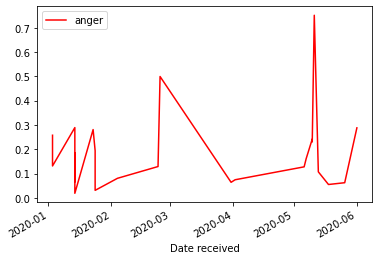

In [39]:
sorted_df.plot(kind='line',x='Date received',y='anger',color='red')

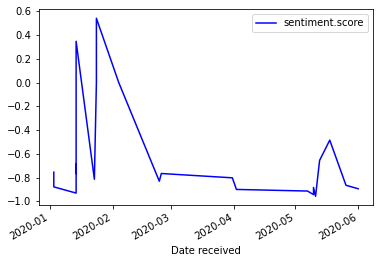

In [40]:
sorted_df.plot(kind='line',x='Date received',y='sentiment.score',color='blue')

Now we can plot both `sentiment.score` and `anger` against time to look for correlations.

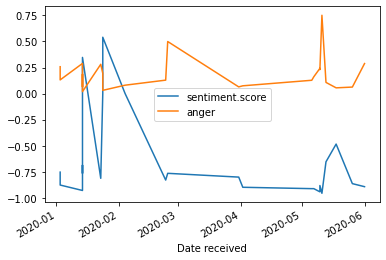

In [41]:
sorted_df.plot(kind='line',x='Date received',y=['sentiment.score','anger'])

### 7.2 Bar graphs

We can sum up the number of times a given `Product` or `Sub-product` appears using the [Python collections library Counter](https://docs.python.org/2/library/collections.html#collections.Counter)

In [42]:
from collections import Counter

Then we'll create a bar graph to see which `Product` are refered to in the most customer complaints.

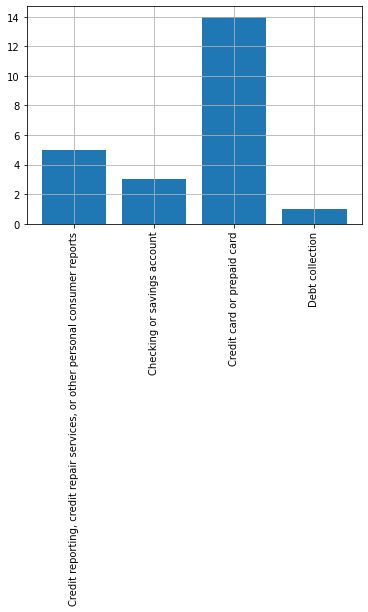

In [43]:
bar_hist = Counter(sorted_df['Product'].replace('\n', ''))

counts = bar_hist.values()
letters = bar_hist.keys()

# graph data
bar_x_locations = np.arange(len(counts))
plt.bar(bar_x_locations, counts, align = 'center')
plt.xticks(bar_x_locations, letters, rotation=90)
plt.grid()
plt.show()

We can do the same for `Sub-product`.

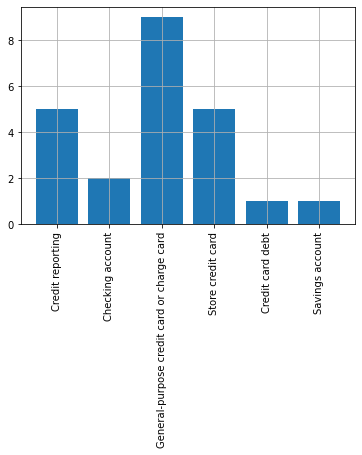

In [44]:
bar_hist = Counter(sorted_df['Sub-product'].replace('\n', ''))

counts = bar_hist.values()
letters = bar_hist.keys()

# graph data
bar_x_locations = np.arange(len(counts))
plt.bar(bar_x_locations, counts, align = 'center')
plt.xticks(bar_x_locations, letters, rotation=90)
plt.grid()
plt.show()

### 7.3 Scatterplot

Now we'll use some matplotlib and numpy code to generate a 3D scatter plot

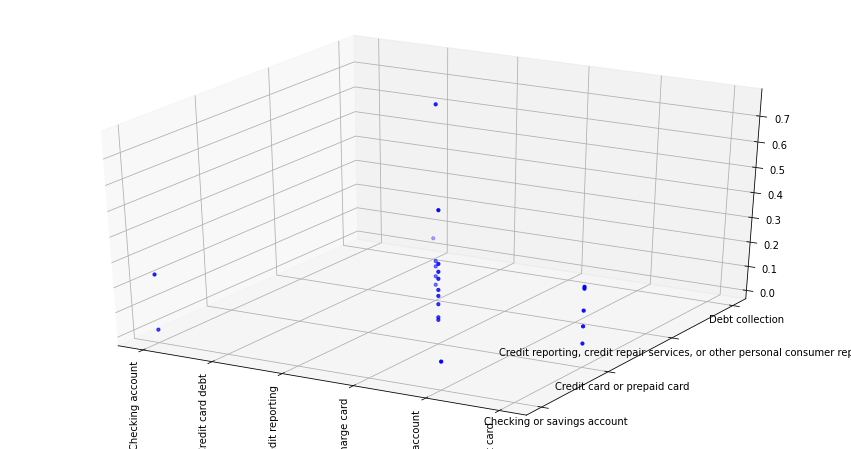

In [45]:
import mpl_toolkits.mplot3d.axes3d as axes3d


Xuniques, X = np.unique(sorted_df['Sub-product'], return_inverse=True)
Yuniques, Y = np.unique(sorted_df['Product'], return_inverse=True)
Z= sorted_df['anger']
fig = plt.figure(figsize= [15,8])
ax = fig.add_subplot(1, 1, 1, projection='3d',autoscale_on=True)
ax.scatter(X, Y, Z, s=10, c='b')
ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques)
plt.xticks(rotation=90)
plt.show()
